# LAB CAE
## Exercise 1

In [225]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset

from torch.utils.data import Dataset
from torch.utils.data import random_split

import CAE
from CAE import load_model, CAE_1_Color

torch.manual_seed(42)

from tqdm import tqdm

In [ ]:
class AutoencoderDataset(Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  
        return image, image  


In [227]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.is_available())
# print(torch.version.cuda)
# print(f"Using device: {device}")

In [228]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.CIFAR10(
    root='', train=True, download=False, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='', train=False, download=False, transform=transform
)

full_dataset = ConcatDataset([train_dataset, test_dataset])

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Ensure all samples are used

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# In the cell above we also split the the data in the desired sets.

In [ ]:
train_autoencoder_dataset = AutoencoderDataset(train_dataset)
val_autoencoder_dataset = AutoencoderDataset(val_dataset)
test_autoencoder_dataset = AutoencoderDataset(test_dataset)

batch_size = 64

train_loader = DataLoader(
    train_autoencoder_dataset,
    batch_size=batch_size,
    shuffle=True,  
    num_workers=0  # number of subprocesses for loading data
)

test_loader = DataLoader(
    test_autoencoder_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

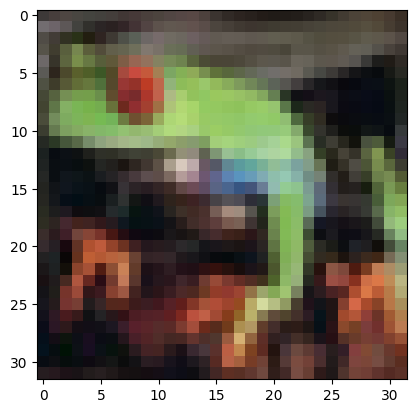

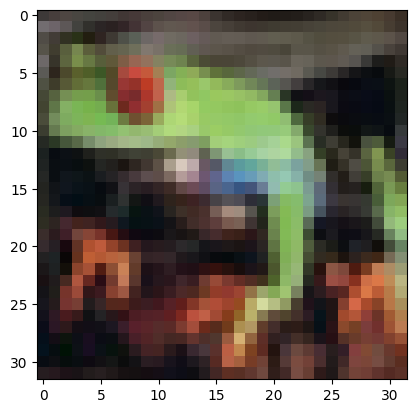

In [ ]:
image, label = train_autoencoder_dataset[0]
imshow(image)
imshow(label)


In [ ]:
import torch.nn as nn
import torch.optim as optim

class SimpleCAE(nn.Module):
    def __init__(self):
        super(SimpleCAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 12, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 16, 3, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(16, 12, 3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(12, 3, 3, padding=1)
        )

    def forward(self, x):
        # print(f"Received input Data with shape: {x.shape}")
        x = self.encoder(x)
        # print(f"Encoder finished and has Latent Space Representation of shape: {x.shape}")
        x = self.decoder(x)
        # print(f"Decoder finished and output has shape: {x.shape}")
        return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)


Model loaded and ready for inference.


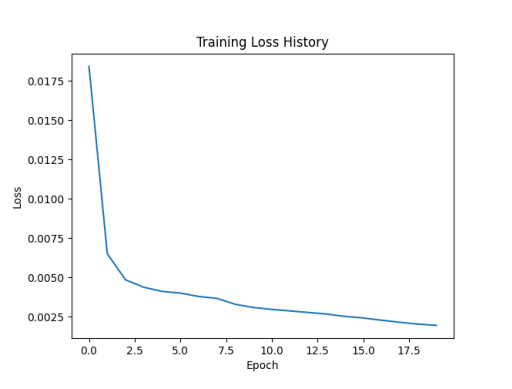

In [ ]:
import CAE
from CAE import SimpleCAE

#Load Model that was previously trained with 20 Epochs and Adam Optimizer
model = CAE.load_model("CAE_from_Assignment.pth", SimpleCAE)
from PIL import Image
import matplotlib.pyplot as plt


loss_history_image = Image.open("loss_history_simple_CAE.png")

plt.imshow(loss_history_image)
plt.axis('off')  
plt.show()

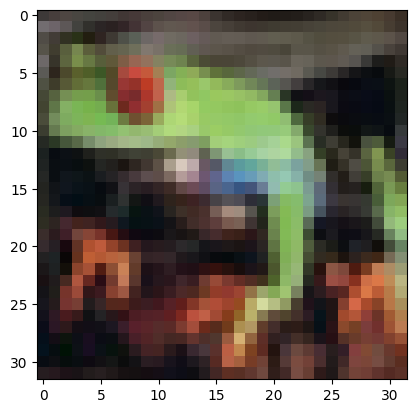

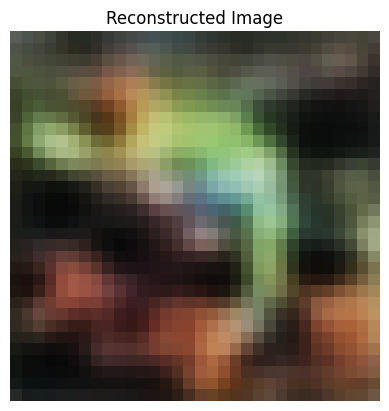

In [ ]:
from torchvision.transforms.functional import to_pil_image

image, _ = train_autoencoder_dataset[0]
imshow(image)  
input_tensor = image.unsqueeze(0)
with torch.no_grad():  
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


In [ ]:
def compute_test_error(model, test_loader, criterion):
    model.eval() 
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs, labels

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)  
            total_samples += inputs.size(0) 

    avg_loss = total_loss / total_samples
    return avg_loss


criterion = nn.MSELoss()
test_error = compute_test_error(model, test_loader, criterion)
print(f'Test Error (MSE Loss): {test_error:.4f}')


100%|██████████| 94/94 [00:02<00:00, 40.42it/s]

Test Error (MSE Loss): 0.0043


As you can see the test error from the base CAE is 0.0043, altough we can start seeing the frog in the image when looking at the target image the decoded image is quite blurry, this could be due to the simple upsampling (sort of knn) we perform to get the image back to a higher dimension. Using a learnable upsampling method like transposed convolutions could improve the decoding by learning more effective upsampling strategies leading to better reconstruction of features since we could learn how to "upsample" features.


## Exercise 2

In [236]:
print(model.encode(image).shape)

torch.Size([16, 8, 8])


This means the Latent space is of size 1024. (We have 16 channels or feature maps each 8x8 in size)

Model loaded and ready for inference.


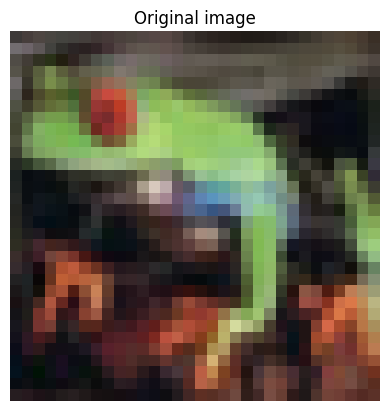

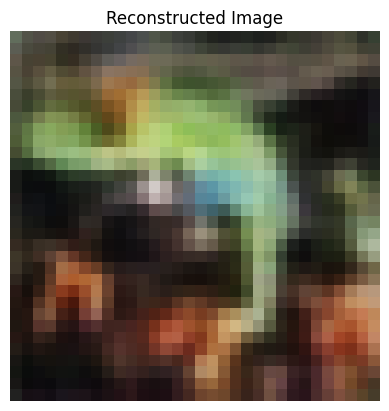

100%|██████████| 94/94 [00:02<00:00, 45.33it/s]

Test Error(MSE) for CAE_1: 0.0018


In [ ]:
from CAE import CAE_1

#Removed pooling and up sampling in favour of trainable dimensionality increase and decrease
model = CAE.load_model("CAE1.pth", CAE_1)
with torch.no_grad():  
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)

img_tens = torch.clamp(input_tensor.squeeze(0).cpu(), 0,1)
img_orig = to_pil_image(img_tens)

plt.imshow(img_orig)
plt.title("Original image")
plt.axis('off')
plt.show()

plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()
print(f"Test Error(MSE) for CAE_1: {CAE.compute_test_error(model, test_loader, criterion):.4f}")

In [238]:
print(model.encode(input_tensor).shape)

torch.Size([1, 16, 8, 8])


As mentioned before by using a learnable upsamling method we reduce our reconstruction error by a factor of ~3 while keeping our latent space the same size (1024)

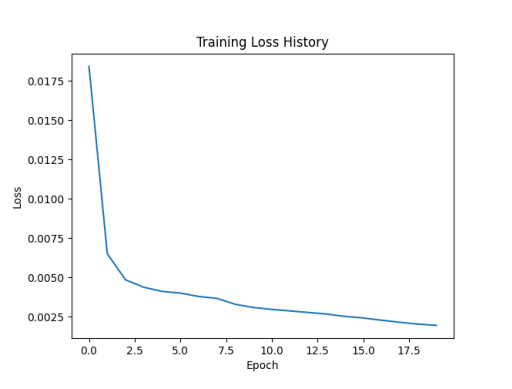

In [ ]:
loss_history_image = Image.open("cae1_loss_history.png")

# Display the image
plt.imshow(loss_history_image)
plt.axis('off')  
plt.show()

Model loaded and ready for inference.


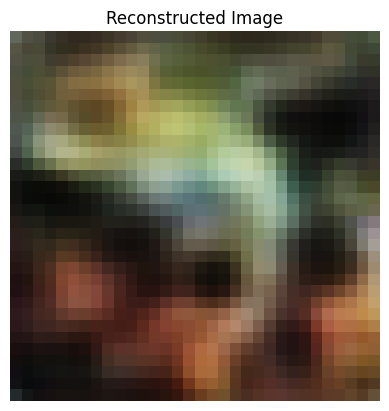

100%|██████████| 94/94 [00:02<00:00, 40.70it/s]

Test Error(MSE) for CAE_2: 0.0051


In [ ]:
from CAE import CAE_2

#Reduced Latent space to showcase its impact
model = CAE.load_model("CAE2.pth", CAE_2)
with torch.no_grad():  
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()
print(f"Test Error(MSE) for CAE_2: {CAE.compute_test_error(model, test_loader, criterion):.4f}")

In [241]:
print(model.encode(input_tensor).shape)

torch.Size([1, 4, 8, 8])


In this CAE configuration we have a larger bottleneck compared to the baseline config due to a smaller latent space.(256)As you can see the reconstruction error is even larger then our intial simplecae, this is probably due to a smaller latent space that increases feature compression, which can be effective up to a certain point. At this point, the model can still encode class specific features reasonably well as seen in the image, but we are beginning to see diminishing returns compression wise. This high level of compression starts to therefore limit the network's ability encode sufficient detail, making it harder to accurately reconstruct the frog in the decoded image.

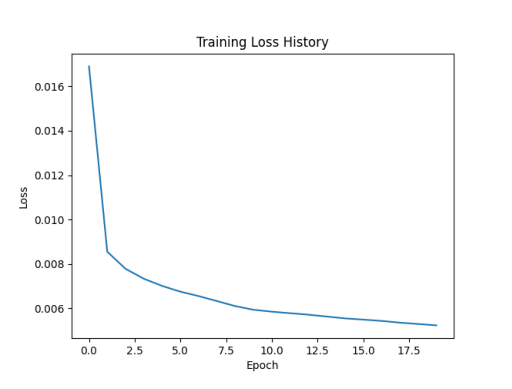

In [ ]:
loss_history_image = Image.open("cae2_loss_history.png")

# Display the image
plt.imshow(loss_history_image)
plt.axis('off')  
plt.show()

Therefore to answer the question: Is there an obvious correlation between the size of the latent space representation and the reconstruction error?

Yes there is a correlation since if we decrease the latent space representation we need to compress more of the information of each picture in a lower dimension latent space leading to higher compression of the original image and thus resulting in higher construction loss inversely if we increase the latent space we can capture more features of the encoded images and therefore make better reconstructions given we have more information to decode with.

## Exercise 3

Model loaded and ready for inference.


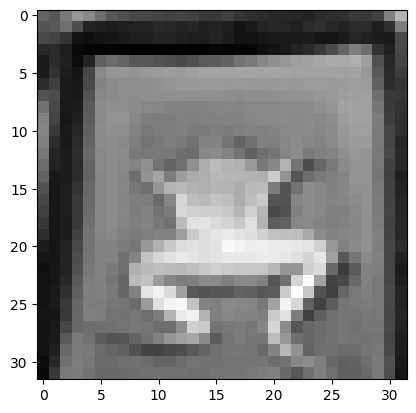

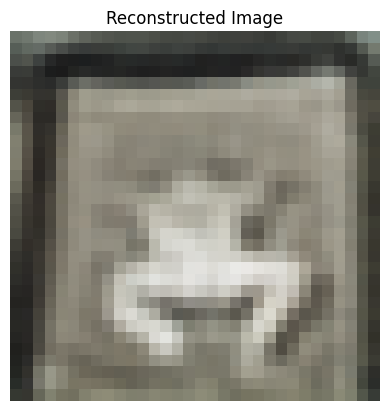

100%|██████████| 47/47 [00:18<00:00,  2.59it/s]

Test Error(MSE) for CAE_2: 0.0073


In [ ]:
from CAE import CAE_1_Color
train_color_loader,test_color_loader=CAE.get_DataLoaders(CAE.ColorEncoderDataset)
model = CAE.load_model("CAE1_color.pth", CAE_1_Color)

image, _ = train_autoencoder_dataset[2]
image=transforms.Grayscale(num_output_channels=1)(image)
plt.imshow(image[0],cmap='gray')
plt.show()
input_tensor = image.unsqueeze(0)
with torch.no_grad(): 
    reconstructed_tensor = model(input_tensor)
reconstructed_tensor = reconstructed_tensor.squeeze(0).cpu()
reconstructed_tensor = torch.clamp(reconstructed_tensor, 0, 1)
reconstructed_image = to_pil_image(reconstructed_tensor)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()
print(f"Test Error(MSE) for CAE_2: {CAE.compute_test_error(model, test_color_loader, criterion):.4f}")

As you can see in the image above there is some color starting to be reconstructed but it is very dim and hardly noticable, this is likely due to the complexity of mapping grayscale intensities to color values especially since our images has a wide variety of colors it will be hard to pinpoint specific color values for a given greyscale intensity.

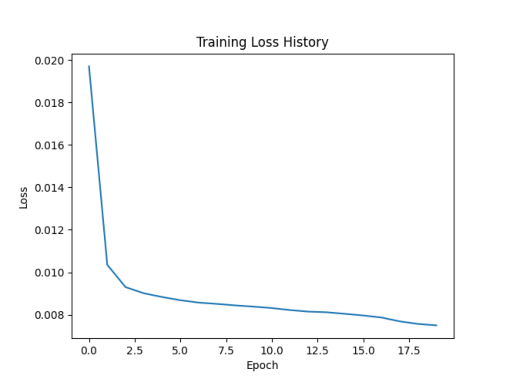

In [ ]:
loss_history_image = Image.open("cae1_color_loss_history.png")

# Display the image
plt.imshow(loss_history_image)
plt.axis('off')  
plt.show()

To the question: What aspects of the architecture/hyperparameters/optimization could be improved upon to fit the model more adequately to this application?

There are multiple things one can try, perhaps implementing some attention mechanisms might capture long range dependencies for certain parts of the image and learn to recognize more spatial dependencies and learn where to focus in the image, which can help in the correct coloring of specific objects.regions. Also we could experiment with different batch sizes of train with more epochs to try and let the model learn for longer or with distributions pieces of the training set. Also looking at other loss functions could improve the reconstruction by using for exampe cross-entropy.

we also tried predicting only the chrominance component which is the proportion of the image determining the colors. By predicting only the chrominance we dont need to predict other features since we can extract these from the grayscale image. The predicted chrominance can then be merged with the luminance captured in grayscale to reconstruct the full image. therefore this approach simplifies the models task by focusing solely on predicting color information, which can lead to improved reconstruction of the image. 

In [ ]:
def reconstruct_color_image(grayscale, predicted_uv):
    # Convert grayscale and predicted_uv to numpy arrays (H, W)
    y_channel = grayscale.detach().numpy()[0] * 255 
    u_channel = predicted_uv.detach().numpy()[0] * 127.5 + 128  # [-1, 1] -> [0, 255]
    v_channel = predicted_uv.detach().numpy()[1] * 127.5 + 128  # [-1, 1] -> [0, 255]

    yuv_image = np.stack((y_channel, u_channel, v_channel), axis=-1)

    yuv_image = yuv_image.astype(np.uint8)
    yuv_image_pil = Image.fromarray(yuv_image, 'YCbCr')
    rgb_image_pil = yuv_image_pil.convert('RGB')
    rgb_image = np.array(rgb_image_pil)

    return rgb_image

Model loaded and ready for inference.


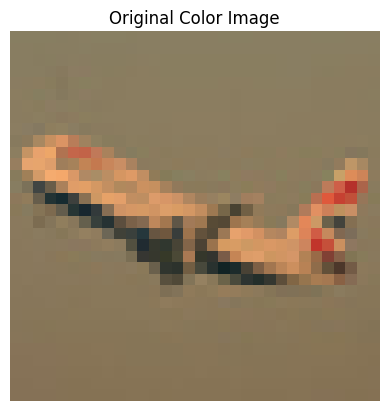

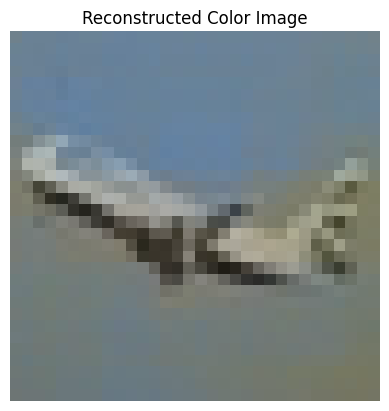

100%|██████████| 47/47 [00:18<00:00,  2.57it/s]

Test Error (MSE Loss): 0.0118


In [ ]:
from CAE import CAE_Chrominance
train_color_loader, test_color_loader = CAE.get_DataLoaders(CAE.ChrominanceEncoderDataset)

model = load_model("cae_chrominance.pth", CAE_Chrominance)
model = model.cpu()
model.eval()

grayscale, _ = test_color_loader.dataset[0]

color_image_tensor, _ = test_color_loader.dataset.dataset[0]  

grayscale_input = grayscale.unsqueeze(0)  

# Predict UV channels
with torch.no_grad():
    predicted_uv = model(grayscale_input)

predicted_uv = predicted_uv.squeeze(0)

original_color_image = color_image_tensor.permute(1, 2, 0).numpy()

plt.imshow(original_color_image)
plt.title('Original Color Image')
plt.axis('off')
plt.show()

reconstructed_color_image = reconstruct_color_image(grayscale, predicted_uv)
plt.imshow(reconstructed_color_image)
plt.title('Reconstructed Color Image')
plt.axis('off')
plt.show()
criterion = nn.MSELoss()
test_error = compute_test_error(model, test_color_loader, criterion)
print(f'Test Error (MSE Loss): {test_error:.4f}')



As we can see this already improves our prediction of the colored image altough not perfect however the alterations to architecture/hyperparameters/optimization and others that was discussed above could also be used in this model to try and make it decode grayscale to color even better.

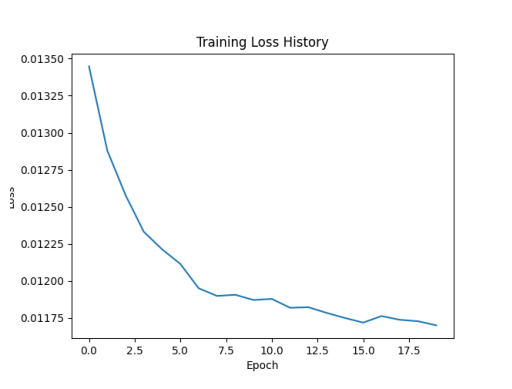

In [ ]:
loss_history_image = Image.open("cae_chrominance_loss.png")

plt.imshow(loss_history_image)
plt.axis('off')  
plt.show()

# Thanks for your attention goodbye!